# Toy 8: Convex function

Represent engineering-like problems with trade-offs


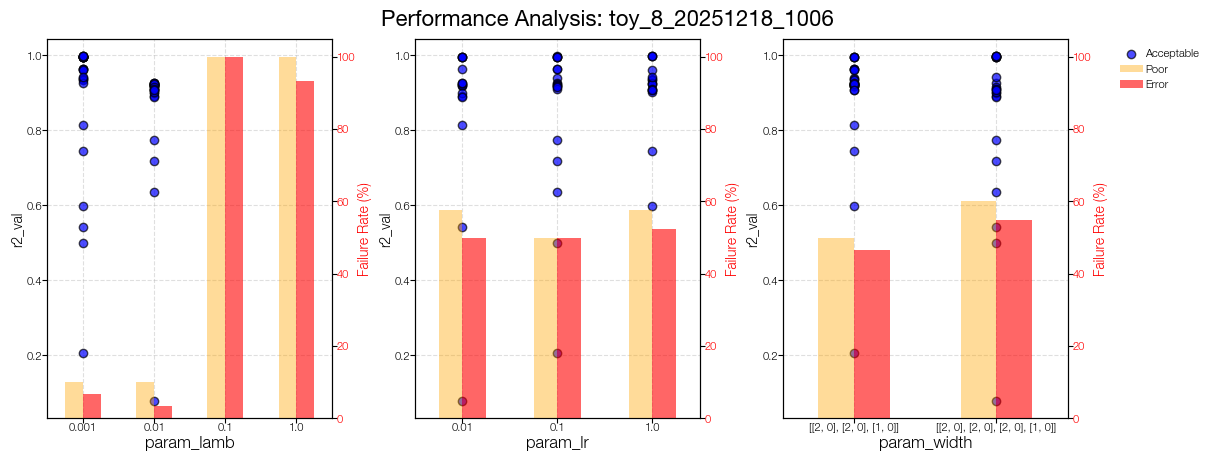

In [1]:
import torch
import os
from kan.custom import MultKAN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from kan.experiments.multkan_hparam_sweep_materials import plot_parameter_performance

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures", "toy8")
os.makedirs(save_dir, exist_ok=True)

f_param = "toy_8_20251218_1006"
save_heading = os.path.join(save_dir, f_param + "_analysis")
d_opt = pd.read_excel(os.path.join(root_dir, 'multkan_sweep_autosave', f_param + ".xlsx"), sheet_name='best_avg_by_params')
d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()

plot_parameter_performance(f_param, root_dir)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
feature_range = (0.1, 0.9)

name_X = ["x1", "x2"]
name_y = "y"

x1_grid = np.linspace(-1, 1, 40)
x2_grid = np.linspace(-1, 1, 40)

x1, x2 = np.meshgrid(x1_grid, x2_grid)
X = np.stack((x1.flatten(), x2.flatten()), axis=1)
y = x1 ** 2 / (x2 + 1.08) / 1.8
y = y.flatten().reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

scaler_X = MinMaxScaler(feature_range=feature_range)
scaler_y = MinMaxScaler(feature_range=feature_range)

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)
dataset_original = {
    'train_input': torch.tensor(X_train_norm, dtype=torch.float32, device=device),
    'train_label': torch.tensor(y_train_norm, dtype=torch.float32, device=device),
    'test_input': torch.tensor(X_test_norm, dtype=torch.float32, device=device),
    'test_label': torch.tensor(y_test_norm, dtype=torch.float32, device=device),
    'val_input': torch.tensor(X_val_norm, dtype=torch.float32, device=device),
    'val_label': torch.tensor(y_val_norm, dtype=torch.float32, device=device),
}

전체 데이터셋 크기: 1600
훈련셋 크기: 1024 (64.0%)
검증셋 크기: 256 (16.0%)
테스트셋 크기: 320 (20.0%)


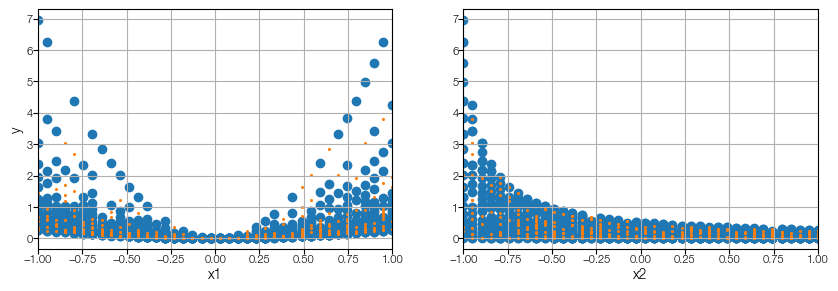

In [3]:
import matplotlib.pyplot as plt

num_input = X.shape[1]
fig, axs = plt.subplots(1, num_input, figsize=(10, 3))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X_train[:, i], y_train)
    ax.scatter(X_test[:, i], y_test, s=1.5)
    ax.set_xlabel(name_X[i])
    ax.grid()
axs[0].set_ylabel(name_y)
plt.show()

{'grid_range': '[0.1, 0.9]', 'lamb': 0.001, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.5, 'lamb_entropy': 0.1, 'lr': 0.01, 'prune': True, 'pruning_th': 0.05, 'stop_grid_update_step': 20, 'width': '[[2, 0], [2, 0], [1, 0]]'}


| train_loss: 1.47e-02 | test_loss: 9.93e-03 | reg: 1.46e+00 | : 100%|█| 50/50 [00:09<00:00,  5.10it


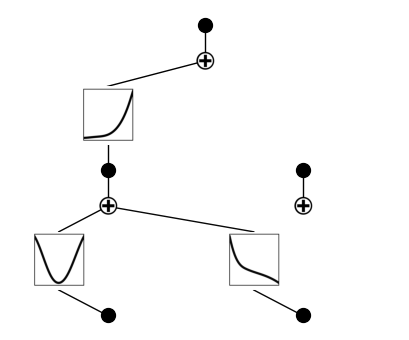

| train_loss: 1.57e-02 | test_loss: 1.10e-02 | reg: 3.33e+00 | : 100%|█| 50/50 [00:09<00:00,  5.19it


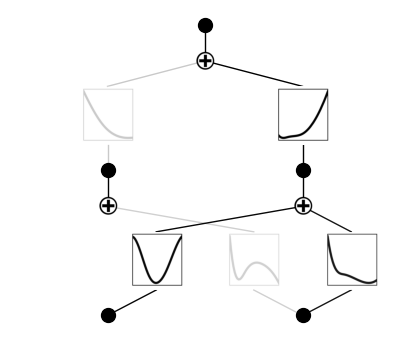

| train_loss: 2.21e-02 | test_loss: 1.52e-02 | reg: 1.76e+00 | : 100%|█| 50/50 [00:10<00:00,  4.79it


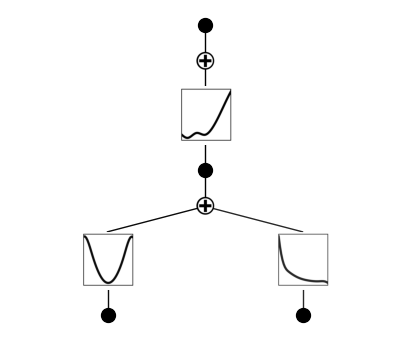

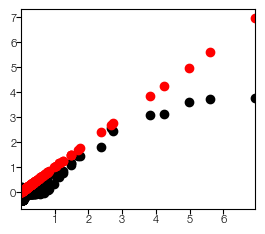

TrialResult(params={'grid_range': (0.1, 0.9), 'lamb': 0.001, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.5, 'lamb_entropy': 0.1, 'lr': 0.01, 'prune': True, 'pruning_th': 0.05, 'stop_grid_update_step': 20, 'width': [[2, 0], [2, 0], [1, 0]]}, val_loss=0.3100900650024414, train_loss=0.2918016314506531, test_loss=0.2860613763332367, r2_train=0.726532184971677, r2_val=0.7470124632565082, r2_test=0.6278369673649776, seed=0, device='cpu', spline_train_loss=0.04335842654109001, spline_test_loss=0.03543616831302643)


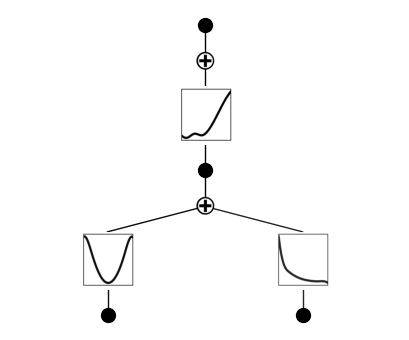

In [4]:
from kan.experiments.multkan_hparam_sweep_materials import evaluate_params
params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}
print(params)

params['grid_range'] = feature_range
# params['symbolic'] = False
# params['max_grid'] = 5
# params['steps'] = 10
# params['pruning_th'] = 0.01

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm, 0, scaler_y, device.type,
    save_heading=save_heading
)
print(res)
model.plot()
plt.show()

Best value at boundary.
r2 is 0.9532604217529297
fixing (0,0,0) with abs, r2=0.97, c=3
r2 is 0.9981492161750793
fixing (0,1,0) with 1/x^2, r2=1.0, c=2
Best value at boundary.
r2 is 0.9017322063446045
fixing (1,0,0) with tan, r2=0.9, c=3


| train_loss: 3.89e-02 | test_loss: 2.13e-01 | reg: 3.00e-01 | : 100%|█| 50/50 [00:01<00:00, 43.98it


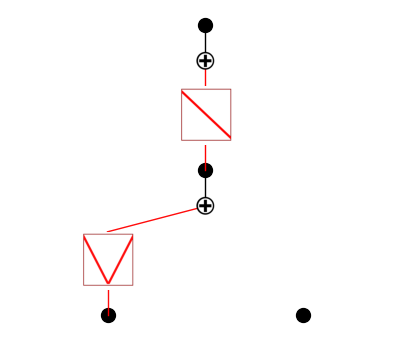

0.0023*tan(0.0022*Abs(10.0*x_1 - 5.0) - 1.5908 + 0.0003/(-x_2 - 0.0536)**2) - 0.072

In [5]:
from kan.utils import ex_round
model.auto_symbolic(weight_simple=0, a_range=(-50,50), b_range=(-50,50))
model.fit(dataset, **fit_kwargs)
model.plot()
plt.show()
ex_round(model.symbolic_formula()[0][0], 4)

{'train': -7.316170781937984, 'test': -11.967677263818148}


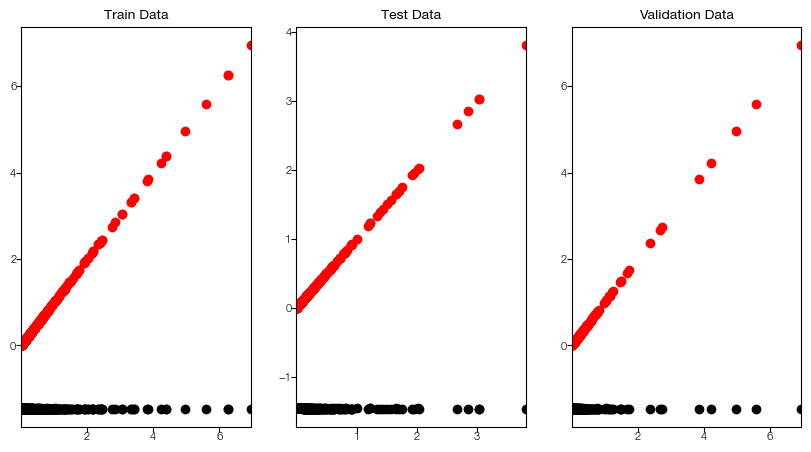

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test = model.forward(x=dataset['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset['train_input']).detach().cpu().numpy()
y_pred_norm_val = model.forward(x=dataset['val_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)
y_pred_val = scaler_y.inverse_transform(y_pred_norm_val)
# y_train = dataset['train_label']
# y_test = dataset['test_label']

r2_score = {
    "train": r2_score(y_train, y_pred_train),
    "test": r2_score(y_test, y_pred_test),
}
print(r2_score)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='r')
ax_train.scatter(y_train, y_pred_train, color='k')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='r')
ax_test.scatter(y_test, y_pred_test, color='k')
ax_test.set_title("Test Data")

ax_test = ax[2]
ax_test.scatter(y_val, y_val, color='r')
ax_test.scatter(y_val, y_pred_val, color='k')
ax_test.set_title("Validation Data")

plt.show()
plt.show()

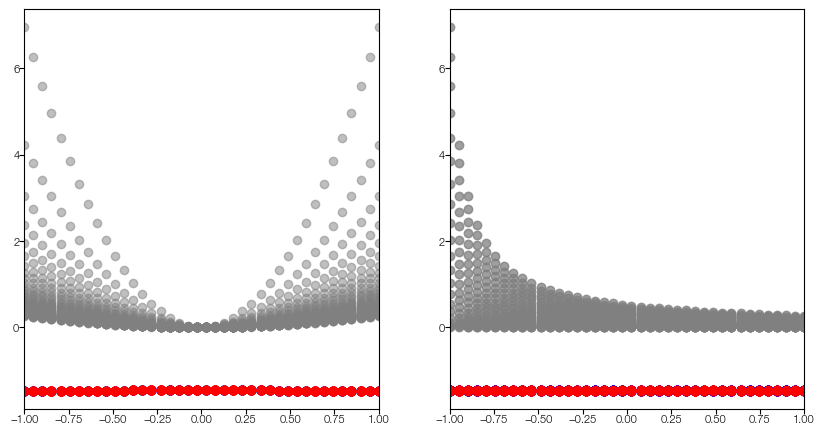

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X[:,i], y, c='gray', alpha=0.5)
    ax.scatter(X_train[:, i], y_pred_train, c='b', label='Train')
    ax.scatter(X_test[:, i], y_pred_test, c='r', label='Train')


Text(0, 0.5, 'Attribution score')

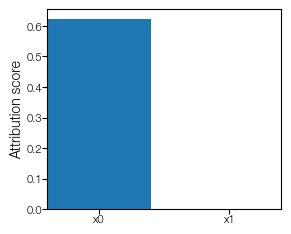

In [8]:
fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

Layer 0 : in 0 -- out 0
Slope: [0.001028926926665008, -0.0009399702539667487, -0.0006689372239634395, -0.00021931223454885185, 0.0002688071399461478, 0.0006822209106758237, -0.0017575953679624945]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Inflection point: None
Layer 0 : in 1 -- out 0
Slope: [-0.0036509151104837656, -0.00021108321379870176, -0.00012653210433200002, -3.927081706933677e-05, -4.877249011769891e-06, 5.030451575294137e-05, -0.0003640690119937062]
[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
Inflection point: None


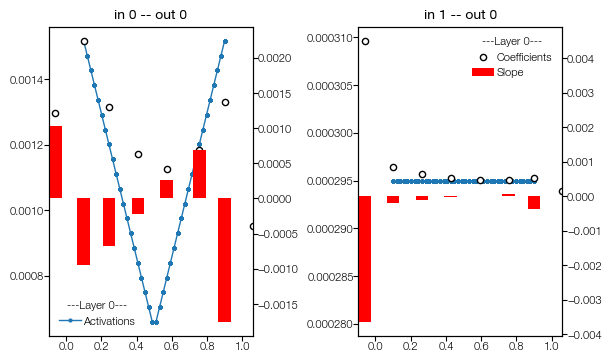

In [9]:
def find_index_sign_revert(data_list, epsilon=5e-3):
    """
    Finds the first index where the sign changes and persists for
    more than one element.

    Values with absolute magnitude smaller than epsilon are treated as having the same sign as the previous element, effectively ignoring small fluctuations around zero.

    Args:
        data_list (list): A list of numbers.
        epsilon (float): The threshold below which a value is considered to have "no sign change" relative to the previous value.

    Returns:
        int or None: The first index of a persistent sign change,
                     or None if no such change is found.
    """
    if len(data_list) < 3:
        return None

    effective_signs = [np.sign(data_list[0])]

    for i in range(1, len(data_list)):
        val = data_list[i]
        prev_sign = effective_signs[-1]

        if abs(val) < epsilon:
            effective_signs.append(prev_sign)
        else:
            effective_signs.append(np.sign(val))
    print(effective_signs)

    # Now search for the persistent sign change using these cleaned signs
    for i in range(1, len(effective_signs) - 1):
        if effective_signs[i] != effective_signs[i-1]:
            if effective_signs[i+1] == effective_signs[i]:
                return i

    return None

depth = len(model.act_fun)
layers_to_plot = [0]
inflection_points = []

for l in layers_to_plot:
    act = model.act_fun[l]
    ni, no = act.coef.shape[:2]
    coef = act.coef.tolist()
    inflection_points_per_layer = []

    fig, axs = plt.subplots(nrows=no, ncols=ni, squeeze=False,
                            figsize=(max(2.5*ni, 6), max(2.5*no, 3.5)),
                            constrained_layout=True)
    second_axs = np.zeros_like(axs)
    for i in range(ni):
        for j in range(no):
            ax = axs[j, i]
            # Gather pre- and post-activations and sort by input
            inputs = model.spline_preacts[l][:, j, i].cpu().detach().numpy()
            outputs = model.spline_postacts[l][:, j, i].cpu().detach().numpy()
            output_spline = model.spline_postsplines[l][:, j, i].cpu().detach().numpy() # without base function values
            coef_node = coef[i][j]
            num_knot = act.grid.shape[1]
            spline_radius = int((num_knot - len(coef_node)) / 2)
            bar_width = min(act.grid[i, 1:] - act.grid[i, :-1]) / 2

            rank = np.argsort(inputs)
            ax.plot(inputs[rank], outputs[rank], marker='o', ms=2, lw=1, label='Activations')
            # ax.plot(inputs[rank], output_spline[rank], marker='^', ms=1, lw=1, label='Splines Only')

            ax2 = ax.twinx()
            second_axs[j, i] = ax2
            ax2.scatter(act.grid[i, spline_radius:-spline_radius], coef_node,
                       s=20, color='white', edgecolor='k', label='Coefficients')
            slope = [x - y for x, y in zip(coef_node[1:], coef_node[:-1])]
            slope_2nd = [(x - y)*10 for x, y in zip(slope[1:], slope[:-1])]
            bars = ax2.bar(act.grid[i, spline_radius:-(spline_radius + 1)], slope,
                    width=bar_width, align='center', color='r', label='Slope')
            ax.set_title(f'in {i} -- out {j}', fontsize=10)

            print(f'Layer {l} : in {i} -- out {j}')
            print(f'Slope: {slope}')

            idx_revert = find_index_sign_revert(slope)
            if idx_revert is None:
                inflection_val = None
            else:
                inflection_val = act.grid[i, spline_radius + idx_revert]
            inflection_points_per_layer.append(inflection_val)

            print(f'Inflection point: {inflection_val}')
    axs[0, 0].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    second_axs[-1, -1].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    inflection_points.append(inflection_points_per_layer)

    plt.show()

In [10]:
# mask_idx = 1
# mask_interval = [-1, inflection_points[0][mask_idx], 1]
#
# x_mask = dataset['train_input'][:, mask_idx]
# y_vals = dataset['train_label'].ravel()
#
# masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
# labels = [f'x{mask_idx}_norm <= {ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
# print([sum(x) for x in masks])
#
# scores_interval = []
# scores_interval_norm = []
# for mask in masks:
#     if np.any(mask.numpy()):
#         x_tensor_masked = dataset['train_input'][mask, :]
#         x_std = torch.std(x_tensor_masked, dim=0).detach().cpu().numpy()
#         model.forward(x_tensor_masked)
#
#         score_masked = model.feature_score.detach().cpu().numpy()
#         score_norm = score_masked / x_std
#         scores_interval.append(score_masked)
#         scores_interval_norm.append(score_norm)
#     else:
#         scores_interval.append(np.zeros(scores_tot.shape))
#         scores_interval_norm.append(np.zeros(scores_tot.shape))
#
# width = 0.25
# fig, ax = plt.subplots(figsize=(6,4))
# xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
# xticklabels = labels
# max_score = max([max(s) for s in scores_interval_norm])
# for idx in range(scores_tot.shape[0]):
#     bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval_norm], width, label=f"x{idx}")
#     ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
# ax.margins(x=0.1)
# ax.set_ylim(0, max_score * 1.1)
#
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
#
# plt.tight_layout()
# plt.show()

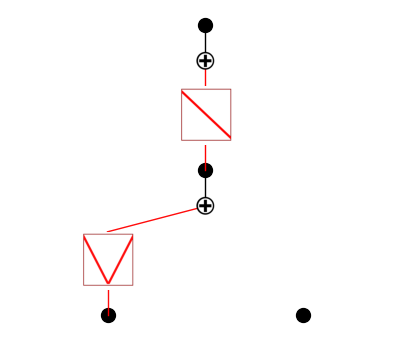

In [11]:
y_pred_norm_test = model.forward(x=dataset_original['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset_original['train_input']).detach().cpu().numpy()
y_pred_norm_val = model.forward(x=dataset_original['val_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)
y_pred_val = scaler_y.inverse_transform(y_pred_norm_val)

# save_heading = os.path.join(save_dir, f_param + "_analysis")
model.plot()
model.saveckpt(path=save_heading + "_model")

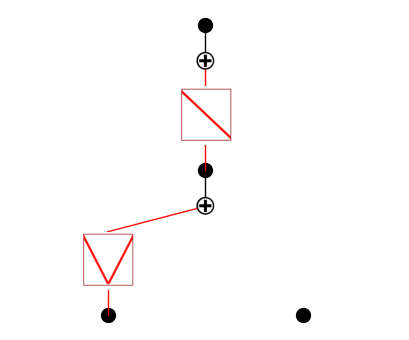

In [12]:
from kan.custom_multkan_ddp import KAN
model2 = KAN.loadckpt(path=r"D:\pykan\github\workflows\Hyein\custom_figures\toy8\toy_8_20251218_1006_analysis_model")
model2.forward(dataset['train_input'])
model2.plot()

<function r2_score at 0x000001718A335900>


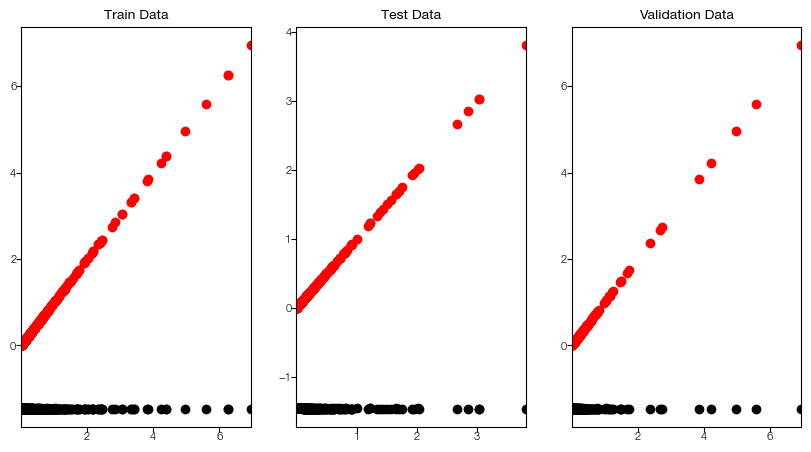

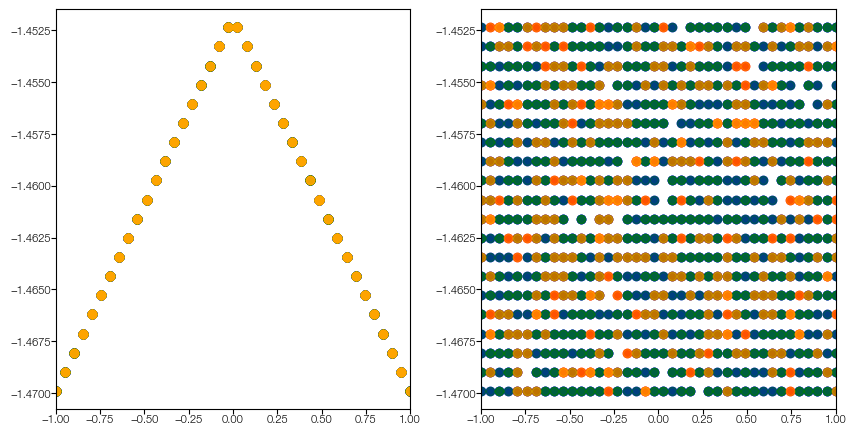

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test_2 = model2.forward(x=dataset_original['test_input']).detach().cpu().numpy()
y_pred_norm_train_2 = model2.forward(x=dataset_original['train_input']).detach().cpu().numpy()
y_pred_norm_val_2 = model2.forward(x=dataset_original['val_input']).detach().cpu().numpy()

y_pred_test_2 = scaler_y.inverse_transform(y_pred_norm_test_2)
y_pred_train_2 = scaler_y.inverse_transform(y_pred_norm_train_2)
y_pred_val_2 = scaler_y.inverse_transform(y_pred_norm_val_2)
# y_train = dataset['train_label']
# y_test = dataset['test_label']

r2_score_2 = {
    "train": r2_score(y_train, y_pred_train_2),
    "test": r2_score(y_test, y_pred_test_2),
}
print(r2_score)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='r')
ax_train.scatter(y_train, y_pred_train_2, color='k')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='r')
ax_test.scatter(y_test, y_pred_test_2, color='k')
ax_test.set_title("Test Data")

ax_test = ax[2]
ax_test.scatter(y_val, y_val, color='r')
ax_test.scatter(y_val, y_pred_val_2, color='k')
ax_test.set_title("Validation Data")

plt.show()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(num_input):
    ax = axs[i]
    # ax.scatter(X[:,i], y, c='gray', alpha=0.5)
    ax.scatter(X_train[:, i], y_pred_train, c='b', label='Train')
    ax.scatter(X_test[:, i], y_pred_test, c='r', label='Test')
    ax.scatter(X_train[:, i], y_pred_train_2, c='g', alpha=0.5, label='Train2')
    ax.scatter(X_test[:, i], y_pred_test_2, c='orange', alpha=0.5, label='Test2')

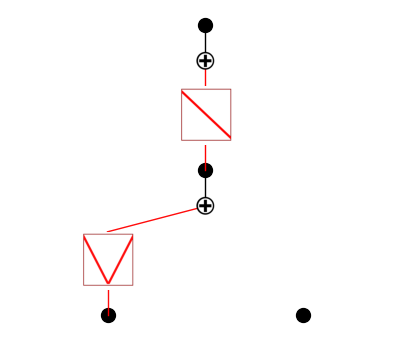

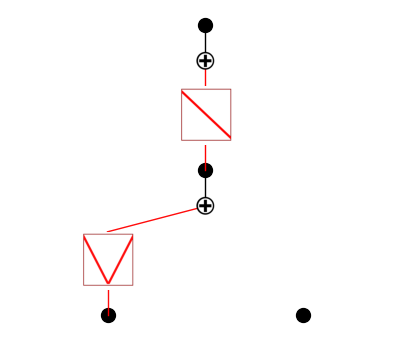

In [14]:
model.plot()
model2.plot()

In [15]:
print(model.act_fun[1].coef.data)
print(model2.act_fun[1].coef.data)

print(len(model.cache_data))
print(len(model2.cache_data))

print(model.act_fun[0].grid.data)
print(model2.act_fun[0].grid.data)

print(model.act_fun[0].scale_base.data)
print(model2.act_fun[0].scale_base.data)

tensor([[[0.1483, 0.1628, 0.0625, 0.0863, 0.1500, 0.0871, 0.1412, 0.2007]]])
tensor([[[0.1483, 0.1628, 0.0625, 0.0863, 0.1500, 0.0871, 0.1412, 0.2007]]])
256
256
tensor([[-0.3800, -0.2200, -0.0600,  0.1000,  0.2439,  0.4079,  0.5720,  0.7561,
          0.9000,  1.0600,  1.2200,  1.3800],
        [-0.3800, -0.2200, -0.0600,  0.1000,  0.2640,  0.4280,  0.5921,  0.7561,
          0.9000,  1.0600,  1.2200,  1.3800]])
tensor([[-0.3800, -0.2200, -0.0600,  0.1000,  0.2439,  0.4079,  0.5720,  0.7561,
          0.9000,  1.0600,  1.2200,  1.3800],
        [-0.3800, -0.2200, -0.0600,  0.1000,  0.2640,  0.4280,  0.5921,  0.7561,
          0.9000,  1.0600,  1.2200,  1.3800]])
tensor([[ 1.1607e-03],
        [-8.5139e-05]])
tensor([[ 1.1607e-03],
        [-8.5139e-05]])


In [16]:
print(model.spline_preacts[0][0])
print(model2.spline_preacts[0][0])

print(model.spline_preacts[1][0])
print(model2.spline_preacts[1][0])

print(model.spline_postacts[0][0])
print(model2.spline_postacts[0][0])

print(model.symbolic_enabled)
print(model2.symbolic_enabled)

tensor([[0.4077, 0.5923]])
tensor([[0.4077, 0.5923]])
tensor([[0.0011]])
tensor([[0.0011]])
tensor([[0.0008, 0.0003]])
tensor([[0.0008, 0.0003]])
True
True


In [17]:
for p1, p2 in zip(model.parameters(), model2.parameters()):
    print(p1)
    if not torch.equal(p1.data, p2.data):
        print("Parameters are NOT exactly the same!")

Parameter containing:
tensor([0.])
Parameter containing:
tensor([1.])
Parameter containing:
tensor([0.])
Parameter containing:
tensor([1.])
Parameter containing:
tensor([0.])
Parameter containing:
tensor([1.])
Parameter containing:
tensor([0.])
Parameter containing:
tensor([1.])
Parameter containing:
tensor([[-0.3800, -0.2200, -0.0600,  0.1000,  0.2439,  0.4079,  0.5720,  0.7561,
          0.9000,  1.0600,  1.2200,  1.3800],
        [-0.3800, -0.2200, -0.0600,  0.1000,  0.2640,  0.4280,  0.5921,  0.7561,
          0.9000,  1.0600,  1.2200,  1.3800]])
Parameter containing:
tensor([[[ 0.0012,  0.0022,  0.0013,  0.0006,  0.0004,  0.0007,  0.0014,
          -0.0004]],

        [[ 0.0045,  0.0009,  0.0006,  0.0005,  0.0005,  0.0005,  0.0005,
           0.0002]]], requires_grad=True)
Parameter containing:
tensor([[0.],
        [0.]])
Parameter containing:
tensor([[ 1.1607e-03],
        [-8.5139e-05]], requires_grad=True)
Parameter containing:
tensor([[0.7457],
        [0.7444]], requires_gra

In [18]:
ex_round(model.symbolic_formula()[0][0], 4)

0.0023*tan(0.0022*Abs(10.0*x_1 - 5.0) - 1.5908 + 0.0003/(-x_2 - 0.0536)**2) - 0.072

In [19]:
ex_round(model2.symbolic_formula()[0][0], 4)

0.0023*tan(0.0022*Abs(10.0*x_1 - 5.0) - 1.5908 + 0.0003/(-x_2 - 0.0536)**2) - 0.072

In [20]:
import torch

def compare_models(model_orig, model_load):
    dict_orig = model_orig.state_dict()
    dict_load = model_load.state_dict()

    keys_orig = set(dict_orig.keys())
    keys_load = set(dict_load.keys())

    print(f"--- [Key List Comparison] ---")
    # 1. 키 존재 여부 체크
    missing_in_load = keys_orig - keys_load
    extra_in_load = keys_load - keys_orig

    if not missing_in_load and not extra_in_load:
        print("✅ All keys match perfectly.")
    else:
        if missing_in_load:
            print(f"❌ Missing keys in loaded model: {missing_in_load}")
        if extra_in_load:
            print(f"❌ Extra keys in loaded model: {extra_in_load}")

    print(f"\n--- [Tensor Value Comparison] ---")
    # 2. 개별 텐서 값 비교
    mismatch_count = 0
    shape_mismatch = 0

    common_keys = sorted(list(keys_orig.intersection(keys_load)))

    for key in common_keys:
        print(key)
        t_orig = dict_orig[key]
        t_load = dict_load[key]

        # Shape 비교
        if t_orig.shape != t_load.shape:
            print(f"📐 Shape Mismatch -> Key: {key} | Orig: {t_orig.shape} | Load: {t_load.shape}")
            shape_mismatch += 1
            continue

        # 데이터 일치 비교 (bit-wise)
        if not torch.equal(t_orig, t_load):
            diff = (t_orig - t_load).abs().max().item()
            print(f"⚠️ Value Mismatch -> Key: {key} | Max Diff: {diff:.2e}")
            mismatch_count += 1

    if mismatch_count == 0 and shape_mismatch == 0:
        print("✅ All tensor values and shapes are identical.")
    else:
        print(f"\nSummary: {mismatch_count} value mismatches, {shape_mismatch} shape mismatches.")

# 사용 예시:
compare_models(model, model2)

--- [Key List Comparison] ---
✅ All keys match perfectly.

--- [Tensor Value Comparison] ---
act_fun.0.coef
act_fun.0.grid
act_fun.0.mask
act_fun.0.scale_base
act_fun.0.scale_sp
act_fun.1.coef
act_fun.1.grid
act_fun.1.mask
act_fun.1.scale_base
act_fun.1.scale_sp
node_bias_0
node_bias_1
node_scale_0
node_scale_1
subnode_bias_0
subnode_bias_1
subnode_scale_0
subnode_scale_1
symbolic_fun.0.affine
symbolic_fun.0.mask
symbolic_fun.1.affine
symbolic_fun.1.mask
✅ All tensor values and shapes are identical.


In [21]:
# 어떤 노드가 심볼릭으로 고정되었는지 나타내는 마스크 확인
for i in range(len(model.symbolic_fun)):
    print(f"Layer {i} Mask Match:", torch.equal(model.symbolic_fun[i].mask, model2.symbolic_fun[i].mask))

Layer 0 Mask Match: True
Layer 1 Mask Match: True


In [22]:
model2.fit(dataset, **fit_kwargs)

| train_loss: 3.89e-02 | test_loss: 2.13e-01 | reg: 3.00e-01 | : 100%|█| 50/50 [00:01<00:00, 43.68it


{'train_loss': [array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.03891521, dtype=float32),
  array(0.0389